# IMDb Review Classifier - Exploratory Data Analysis (EDA)

În acest notebook vom analiza dataset-ul IMDb pentru clasificarea recenziilor în pozitive și negative.

## Încărcarea Dataset-ului

Vom folosi biblioteca `datasets` de la Hugging Face pentru a încărca dataset-ul IMDb.

In [3]:
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np
import sys
sys.path.append('..')
from src.preprocess import clean_text, tokenize_text

# === Configurare stil și dimensiuni implicite ===
sns.set_theme(style="whitegrid")           # Stil coerent pentru toate ploturile
plt.rcParams['figure.figsize'] = (10, 6)    # Dimensiune implicită pentru figuri
plt.rcParams['axes.labelsize'] = 12         # Mărime implicită label axe
plt.rcParams['axes.titlesize'] = 14         # Mărime implicită titluri

In [4]:
# Încărcăm dataset-ul IMDb și îl împărțim în seturi de train, validation și test
raw_ds = load_dataset("imdb")

# 2. Păstrăm setul unsupervised neschimbat
unsupervised_ds = raw_ds["unsupervised"]

# 3. Împărțim train (25k) în train+temp (70/30 stratificat)
split1 = raw_ds["train"].train_test_split(
    test_size=0.30,
    seed=42,
    stratify_by_column="label"
)
train_ds = split1["train"]
temp_ds  = split1["test"]

# 4. Împărțim temp_ds în validation și test (jumătate-jumătate stratificat)
split2 = temp_ds.train_test_split(
    test_size=0.50,
    seed=42,
    stratify_by_column="label"
)
val_ds  = split2["train"]
test_ds = split2["test"]

In [4]:
# Verificăm dimensiunile seturilor de date
print("\nDimensiunile seturilor de date:")
print(f"Training:    {len(train_ds):6d} exemple")
print(f"Validation:  {len(val_ds):6d} exemple")
print(f"Test:        {len(test_ds):6d} exemple")
print(f"Unsupervised: {len(unsupervised_ds):6d} exemple")

# Verificăm distribuția claselor în fiecare set
print("\nDistribuția claselor în fiecare set:")
for name, ds in [
    ("Training", train_ds),
    ("Validation", val_ds),
    ("Test", test_ds)
]:
    label_counts = Counter(ds["label"])
    print(f"\n{name}:")
    for label, count in label_counts.items():
        pct = count / len(ds) * 100
        print(f"  {label} → {count} exemple ({pct:.1f}%)")



Dimensiunile seturilor de date:
Training:     17500 exemple
Validation:    3750 exemple
Test:          3750 exemple
Unsupervised:  50000 exemple

Distribuția claselor în fiecare set:

Training:
  1 → 8750 exemple (50.0%)
  0 → 8750 exemple (50.0%)

Validation:
  0 → 1875 exemple (50.0%)
  1 → 1875 exemple (50.0%)

Test:
  1 → 1875 exemple (50.0%)
  0 → 1875 exemple (50.0%)


In [5]:
# Afișăm exemple de recenzii din fiecare clasă
print("\nExemple de recenzii negative (clasa 0):")
for i, review in enumerate(train_ds.filter(lambda x: x['label'] == 0)['text'][:3]):
    print(f"\nExemplul {i+1}:")
    print("-" * 80)
    print(review[:500] + "..." if len(review) > 500 else review)
    print("-" * 80)

print("\nExemple de recenzii pozitive (clasa 1):")
for i, review in enumerate(train_ds.filter(lambda x: x['label'] == 1)['text'][:3]):
    print(f"\nExemplul {i+1}:")
    print("-" * 80)
    print(review[:500] + "..." if len(review) > 500 else review)
    print("-" * 80)



Exemple de recenzii negative (clasa 0):

Exemplul 1:
--------------------------------------------------------------------------------
OK - the helicopter shots are fantastic, and the director made good use of some of Barcelona's top sights. Otherwise...production value was blown in the first few minutes and the rest of the film felt like a movie of the week. Ellen Pompeo was charming and fun to watch, Abel Folk had the most depth and was very effective, and William Baldwin was...well, William Baldwin. He got to put his martial art training to good use and be a running-jumping-earnest action figure. The rest of the cast was woo...
--------------------------------------------------------------------------------

Exemplul 2:
--------------------------------------------------------------------------------
Just saw the movie this past weekend, I am upset, and disappointed with it. Basically, the movie tells you that immigrants, the ones from former Soviet Union especially, come to this cou

# Statistici descriptive & calitative

Statistici descriptive pentru seturile de date:

Setul de Training:
Număr total de recenzii: 17500
Distribuție clase:
label
1    50.0%
0    50.0%
Name: proportion, dtype: object

Setul de Validare:
Număr total de recenzii: 3750
Distribuție clase:
label
0    50.0%
1    50.0%
Name: proportion, dtype: object

Setul de Test:
Număr total de recenzii: 3750
Distribuție clase:
label
1    50.0%
0    50.0%
Name: proportion, dtype: object


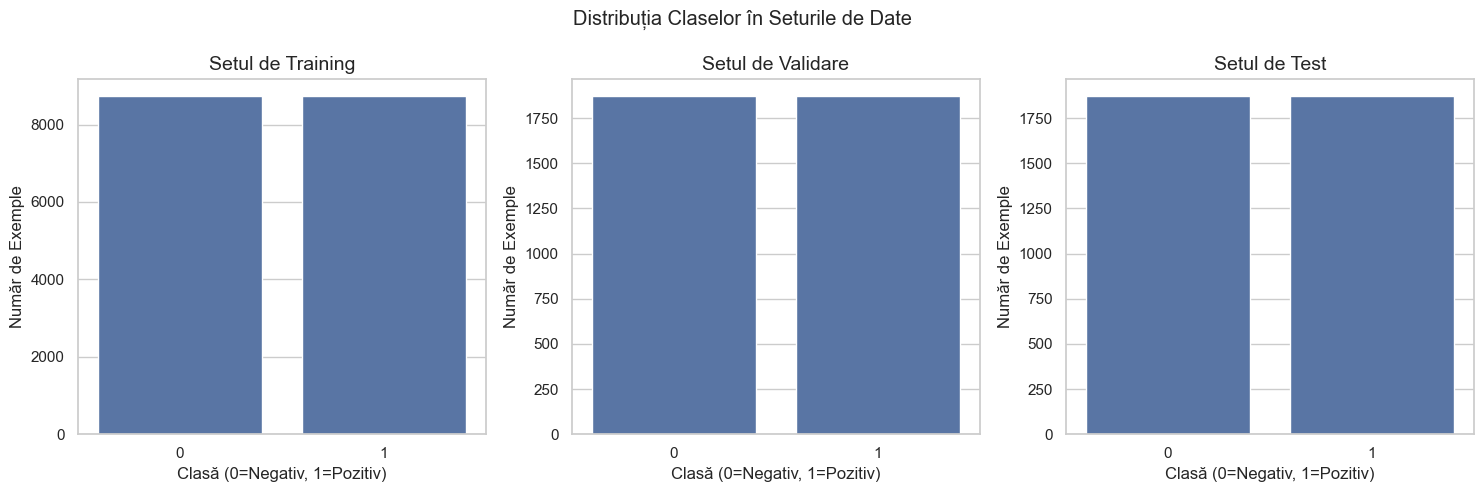

In [5]:
# Convertim seturile de date în DataFrame-uri pentru analiză
train_df = pd.DataFrame(train_ds)
val_df = pd.DataFrame(val_ds)
test_df = pd.DataFrame(test_ds)

# Calculăm statisticile pentru fiecare set
print("Statistici descriptive pentru seturile de date:")
print("\nSetul de Training:")
print(f"Număr total de recenzii: {len(train_df)}")
print(f"Distribuție clase:")
print(train_df['label'].value_counts(normalize=True).apply(lambda x: f"{x:.1%}"))

print("\nSetul de Validare:")
print(f"Număr total de recenzii: {len(val_df)}")
print(f"Distribuție clase:")
print(val_df['label'].value_counts(normalize=True).apply(lambda x: f"{x:.1%}"))

print("\nSetul de Test:")
print(f"Număr total de recenzii: {len(test_df)}")
print(f"Distribuție clase:")
print(test_df['label'].value_counts(normalize=True).apply(lambda x: f"{x:.1%}"))

# Vizualizăm distribuția claselor pentru toate seturile
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Distribuția Claselor în Seturile de Date')

for i, (df, title) in enumerate([
    (train_df, 'Training'),
    (val_df, 'Validare'),
    (test_df, 'Test')
]):
    sns.countplot(data=df, x='label', ax=axes[i])
    axes[i].set_title(f'Setul de {title}')
    axes[i].set_xlabel('Clasă (0=Negativ, 1=Pozitiv)')
    axes[i].set_ylabel('Număr de Exemple')

plt.tight_layout()
plt.show()


Statistici pentru lungimea recenziilor în setul de training:

Lungime în caractere:
Medie: 1323.10
Mediană: 977.00
Mod: 658.00

Lungime în cuvinte:
Medie: 233.52
Mediană: 174.00
Mod: 133.00


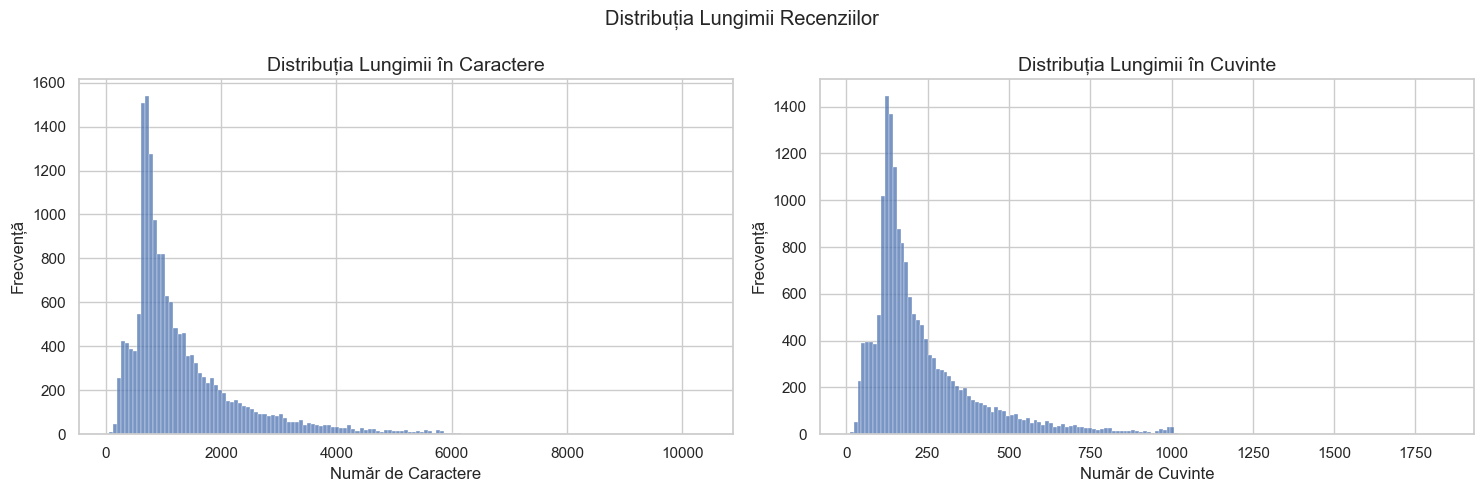

In [6]:
# Calculăm lungimea fiecărei recenzii (număr de caractere și număr de cuvinte)
train_df['char_length'] = train_df['text'].str.len()
train_df['word_count'] = train_df['text'].str.split().str.len()

# Calculăm statisticile pentru lungimea recenziilor
print("Statistici pentru lungimea recenziilor în setul de training:")
print("\nLungime în caractere:")
print(f"Medie: {train_df['char_length'].mean():.2f}")
print(f"Mediană: {train_df['char_length'].median():.2f}")
print(f"Mod: {train_df['char_length'].mode().iloc[0]:.2f}")

print("\nLungime în cuvinte:")
print(f"Medie: {train_df['word_count'].mean():.2f}")
print(f"Mediană: {train_df['word_count'].median():.2f}")
print(f"Mod: {train_df['word_count'].mode().iloc[0]:.2f}")

# Vizualizăm distribuția lungimilor
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Distribuția Lungimii Recenziilor')

# Histogramă pentru lungimea în caractere
sns.histplot(data=train_df, x='char_length', ax=ax1)
ax1.set_title('Distribuția Lungimii în Caractere')
ax1.set_xlabel('Număr de Caractere')
ax1.set_ylabel('Frecvență')

# Histogramă pentru lungimea în cuvinte
sns.histplot(data=train_df, x='word_count', ax=ax2)
ax2.set_title('Distribuția Lungimii în Cuvinte')
ax2.set_xlabel('Număr de Cuvinte')
ax2.set_ylabel('Frecvență')

plt.tight_layout()
plt.show()


Token indices sequence length is longer than the specified maximum sequence length for this model (720 > 512). Running this sequence through the model will result in indexing errors


Statistici pentru lungimea în tokeni:
count    25000.000000
mean       313.871320
std        234.295864
min         13.000000
25%        168.000000
50%        233.000000
75%        382.000000
max       3127.000000
Name: token_length, dtype: float64

Percentile pentru lungimea în tokeni:
25%: 168 tokeni
50%: 233 tokeni
75%: 382 tokeni
90%: 618 tokeni
95%: 806 tokeni
99%: 1206 tokeni


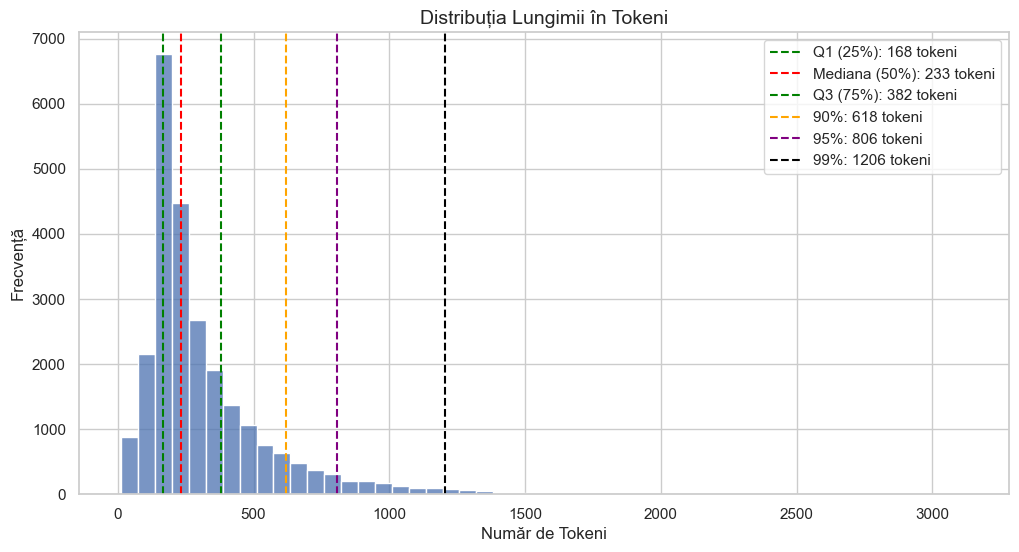


Analiza trunchierii la diferite valori:
La 128 tokeni: 22325 recenzii (89.3%) ar fi trunchiate
La 256 tokeni: 11063 recenzii (44.3%) ar fi trunchiate
La 384 tokeni: 6193 recenzii (24.8%) ar fi trunchiate
La 512 tokeni: 3701 recenzii (14.8%) ar fi trunchiate


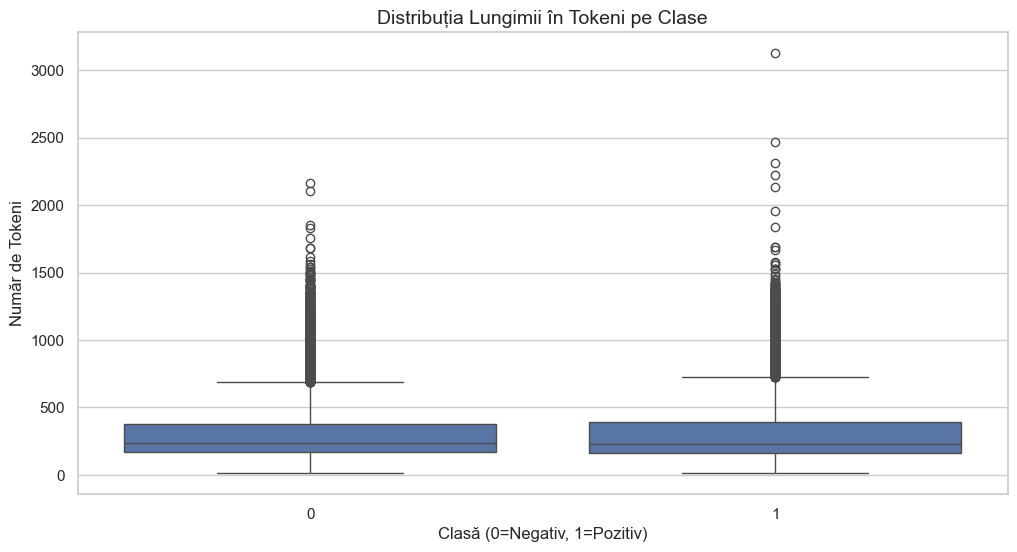


Statistici pentru lungimea în tokeni pe clase:
         count       mean         std   min    25%    50%    75%     max
label                                                                   
0      12500.0  311.98024  226.391155  13.0  171.0  235.0  377.0  2166.0
1      12500.0  315.76240  241.936742  17.0  164.0  231.0  389.0  3127.0


In [7]:
# Analiză pentru determinarea valorii optime de truncare
from transformers import DistilBertTokenizer
import numpy as np

# Inițializăm tokenizer-ul
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Funcție pentru a calcula lungimea în tokeni
def get_token_length(text):
    return len(tokenizer.encode(text))

# Calculăm lungimea în tokeni pentru toate recenziile
train_df['token_length'] = train_df['text'].apply(get_token_length)

# Calculăm statisticile pentru lungimea în tokeni
print("Statistici pentru lungimea în tokeni:")
print(train_df['token_length'].describe())

# Calculăm percentilele pentru lungimea în tokeni
percentiles = [25, 50, 75, 90, 95, 99]
token_percentiles = np.percentile(train_df['token_length'], percentiles)
print("\nPercentile pentru lungimea în tokeni:")
for p, v in zip(percentiles, token_percentiles):
    print(f"{p}%: {v:.0f} tokeni")

# Vizualizăm distribuția lungimilor în tokeni
plt.figure(figsize=(12, 6))
sns.histplot(data=train_df, x='token_length', bins=50)
plt.title('Distribuția Lungimii în Tokeni')
plt.xlabel('Număr de Tokeni')
plt.ylabel('Frecvență')

# Adăugăm liniile pentru percentile
colors = ['green', 'red', 'green', 'orange', 'purple', 'black']
labels = ['Q1 (25%)', 'Mediana (50%)', 'Q3 (75%)', '90%', '95%', '99%']

for p, v, c, l in zip(percentiles, token_percentiles, colors, labels):
    plt.axvline(v, color=c, linestyle='--', label=f'{l}: {v:.0f} tokeni')

plt.legend()
plt.show()

# Analizăm câte recenzii ar fi trunchiate la diferite valori
truncation_values = [128, 256, 384, 512]
print("\nAnaliza trunchierii la diferite valori:")
for value in truncation_values:
    truncated_count = (train_df['token_length'] > value).sum()
    percentage = (truncated_count / len(train_df)) * 100
    print(f"La {value} tokeni: {truncated_count} recenzii ({percentage:.1f}%) ar fi trunchiate")

# Analizăm distribuția lungimilor în tokeni pe clase
plt.figure(figsize=(12, 6))
sns.boxplot(data=train_df, x='label', y='token_length')
plt.title('Distribuția Lungimii în Tokeni pe Clase')
plt.xlabel('Clasă (0=Negativ, 1=Pozitiv)')
plt.ylabel('Număr de Tokeni')
plt.show()

# Afișăm statisticile pentru lungimea în tokeni pe clase
print("\nStatistici pentru lungimea în tokeni pe clase:")
print(train_df.groupby('label')['token_length'].describe())

Percentile pentru lungimea recenziilor:
 Percentil  Lungime (cuvinte)  Lungime (caractere)
        25              127.0               702.00
        50              174.0               979.00
        75              284.0              1614.00
        90              458.0              2617.00
        95              598.0              3432.05
        99              913.0              5213.01


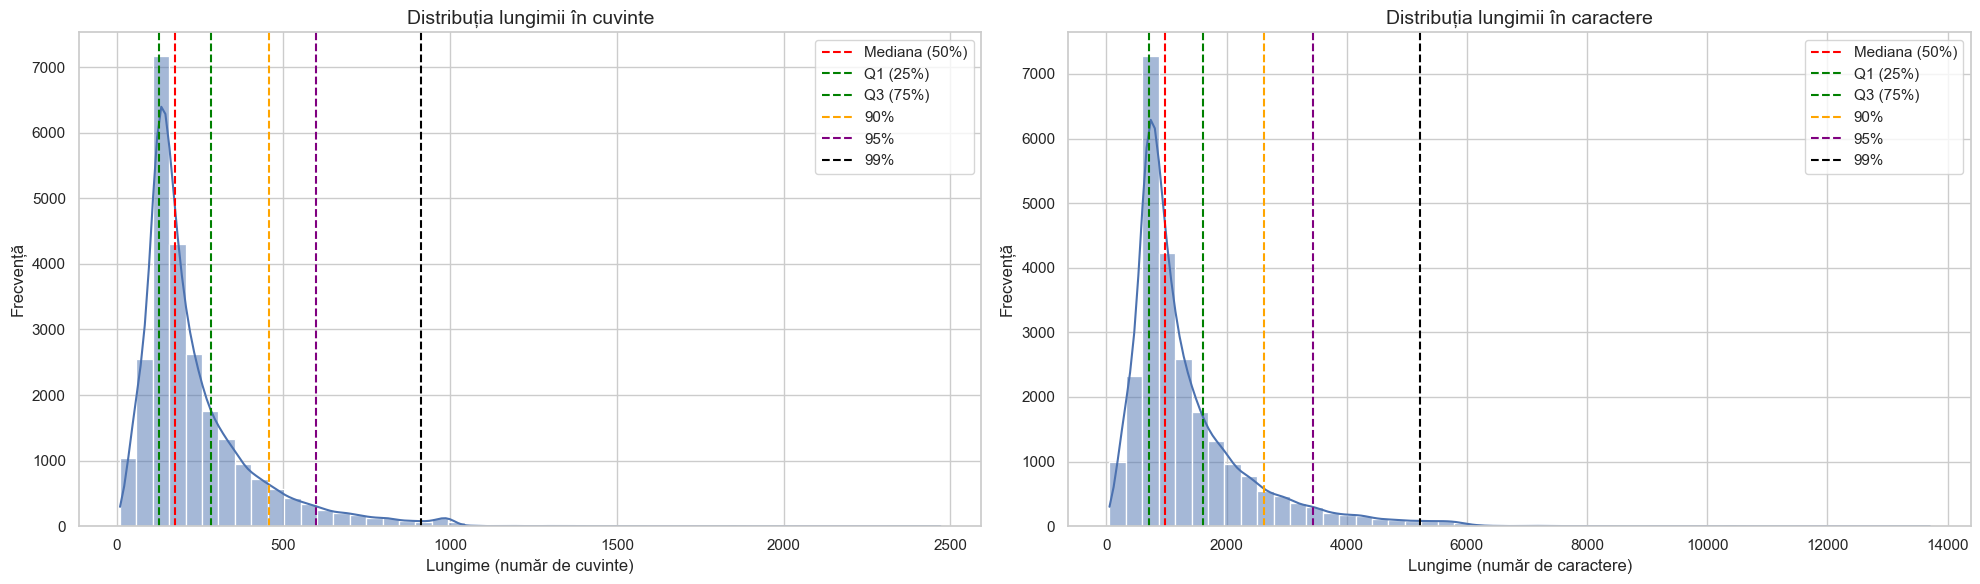


Statistici suplimentare pentru lungimea în cuvinte:
Lungime minimă: 10 cuvinte
Lungime maximă: 2470 cuvinte
Lungime medie: 233.79 cuvinte
Deviație standard: 173.73 cuvinte

Statistici suplimentare pentru lungimea în caractere:
Lungime minimă: 52 caractere
Lungime maximă: 13704 caractere
Lungime medie: 1325.07 caractere
Deviație standard: 1003.11 caractere


In [7]:
# Calculăm lungimea fiecărei recenzii (cuvinte și caractere)
review_word_lengths = [len(review.split()) for review in raw_ds['train']['text']]
review_char_lengths = [len(review) for review in raw_ds['train']['text']]

# Calculăm percentilele
percentiles = [25, 50, 75, 90, 95, 99]
word_percentile_values = np.percentile(review_word_lengths, percentiles)
char_percentile_values = np.percentile(review_char_lengths, percentiles)

# Creăm un DataFrame pentru o afișare mai frumoasă
percentile_df = pd.DataFrame({
    'Percentil': percentiles,
    'Lungime (cuvinte)': word_percentile_values,
    'Lungime (caractere)': char_percentile_values
})

# Afișăm tabelul
print("Percentile pentru lungimea recenziilor:")
print(percentile_df.to_string(index=False))

# Creăm vizualizări pentru ambele tipuri de lungime
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Vizualizare pentru lungimea în cuvinte
sns.histplot(review_word_lengths, bins=50, kde=True, ax=ax1)
ax1.axvline(word_percentile_values[1], color='red', linestyle='--', label='Mediana (50%)')
ax1.axvline(word_percentile_values[0], color='green', linestyle='--', label='Q1 (25%)')
ax1.axvline(word_percentile_values[2], color='green', linestyle='--', label='Q3 (75%)')
ax1.axvline(word_percentile_values[3], color='orange', linestyle='--', label='90%')
ax1.axvline(word_percentile_values[4], color='purple', linestyle='--', label='95%')
ax1.axvline(word_percentile_values[5], color='black', linestyle='--', label='99%')
ax1.set_title('Distribuția lungimii în cuvinte')
ax1.set_xlabel('Lungime (număr de cuvinte)')
ax1.set_ylabel('Frecvență')
ax1.legend()

# Vizualizare pentru lungimea în caractere
sns.histplot(review_char_lengths, bins=50, kde=True, ax=ax2)
ax2.axvline(char_percentile_values[1], color='red', linestyle='--', label='Mediana (50%)')
ax2.axvline(char_percentile_values[0], color='green', linestyle='--', label='Q1 (25%)')
ax2.axvline(char_percentile_values[2], color='green', linestyle='--', label='Q3 (75%)')
ax2.axvline(char_percentile_values[3], color='orange', linestyle='--', label='90%')
ax2.axvline(char_percentile_values[4], color='purple', linestyle='--', label='95%')
ax2.axvline(char_percentile_values[5], color='black', linestyle='--', label='99%')
ax2.set_title('Distribuția lungimii în caractere')
ax2.set_xlabel('Lungime (număr de caractere)')
ax2.set_ylabel('Frecvență')
ax2.legend()

plt.tight_layout()
plt.show()

# Afișăm statistici suplimentare pentru ambele tipuri de lungime
print("\nStatistici suplimentare pentru lungimea în cuvinte:")
print(f"Lungime minimă: {min(review_word_lengths)} cuvinte")
print(f"Lungime maximă: {max(review_word_lengths)} cuvinte")
print(f"Lungime medie: {np.mean(review_word_lengths):.2f} cuvinte")
print(f"Deviație standard: {np.std(review_word_lengths):.2f} cuvinte")

print("\nStatistici suplimentare pentru lungimea în caractere:")
print(f"Lungime minimă: {min(review_char_lengths)} caractere")
print(f"Lungime maximă: {max(review_char_lengths)} caractere")
print(f"Lungime medie: {np.mean(review_char_lengths):.2f} caractere")
print(f"Deviație standard: {np.std(review_char_lengths):.2f} caractere")

In [ ]:
# Verificăm recenziile foarte scurte (< 5 cuvinte)
short_reviews = train_df[train_df['text'].str.split().str.len() < 5]
print(f"\nNumăr de recenzii foarte scurte (< 5 cuvinte): {len(short_reviews)}")

if len(short_reviews) > 0:
    print("\nExemple de recenzii foarte scurte:")
    for i, (text, label) in enumerate(zip(short_reviews['text'], short_reviews['label'])):
        print(f"\nExemplu {i+1} (Clasă: {'Pozitiv' if label == 1 else 'Negativ'}):")
        print(text)

# Verificăm dacă există recenzii goale sau care conțin doar spații
empty_reviews = train_df[train_df['text'].str.strip().str.len() == 0]
print(f"\nNumăr de recenzii goale: {len(empty_reviews)}")

if len(empty_reviews) > 0:
    print("\nExemple de recenzii goale:")
    for i, (text, label) in enumerate(zip(empty_reviews['text'], empty_reviews['label'])):
        print(f"\nExemplu {i+1} (Clasă: {'Pozitiv' if label == 1 else 'Negativ'}):")
        print(text)


Număr de recenzii foarte scurte (< 5 cuvinte): 0

Număr de recenzii goale: 0


### Vizualizări de bază

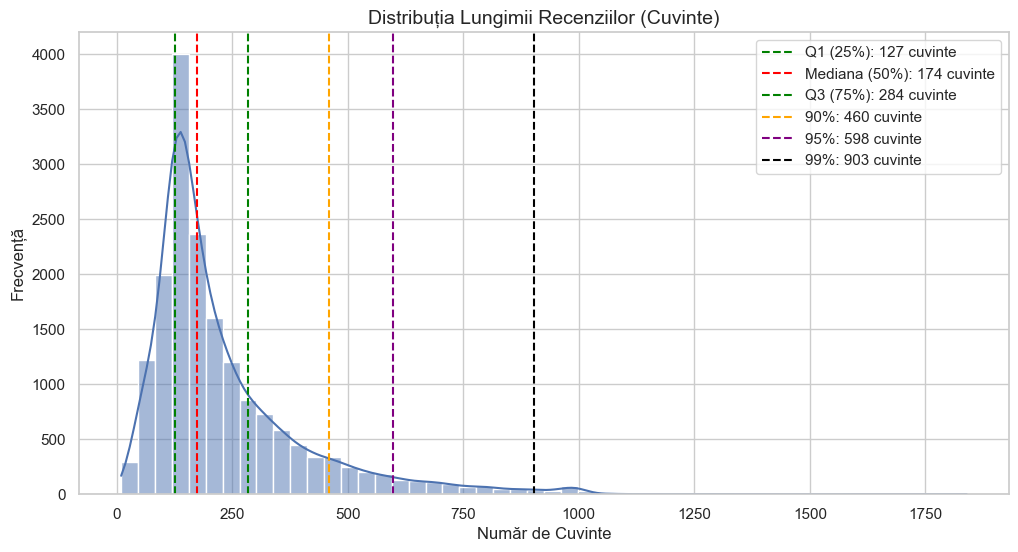


Statistici pentru lungimea recenziilor în cuvinte:
Medie: 233.52 cuvinte
Mediană: 174.00 cuvinte
Mod: 133.00 cuvinte
Deviație standard: 172.70 cuvinte


In [9]:
# Creăm histograma cu distribuția lungimii recenziilor (cuvinte) și linie KDE
plt.figure(figsize=(12, 6))
sns.histplot(data=train_df, x='word_count', bins=50, kde=True)
plt.title('Distribuția Lungimii Recenziilor (Cuvinte)')
plt.xlabel('Număr de Cuvinte')
plt.ylabel('Frecvență')

# Adăugăm liniile pentru percentile importante
percentiles = [25, 50, 75, 90, 95, 99]
percentile_values = np.percentile(train_df['word_count'], percentiles)

# Adăugăm liniile verticale pentru percentile
colors = ['green', 'red', 'green', 'orange', 'purple', 'black']
labels = ['Q1 (25%)', 'Mediana (50%)', 'Q3 (75%)', '90%', '95%', '99%']

for p, v, c, l in zip(percentiles, percentile_values, colors, labels):
    plt.axvline(v, color=c, linestyle='--', label=f'{l}: {v:.0f} cuvinte')

plt.legend()
plt.show()

# Afișăm și statisticile relevante
print("\nStatistici pentru lungimea recenziilor în cuvinte:")
print(f"Medie: {train_df['word_count'].mean():.2f} cuvinte")
print(f"Mediană: {train_df['word_count'].median():.2f} cuvinte")
print(f"Mod: {train_df['word_count'].mode().iloc[0]:.2f} cuvinte")
print(f"Deviație standard: {train_df['word_count'].std():.2f} cuvinte")

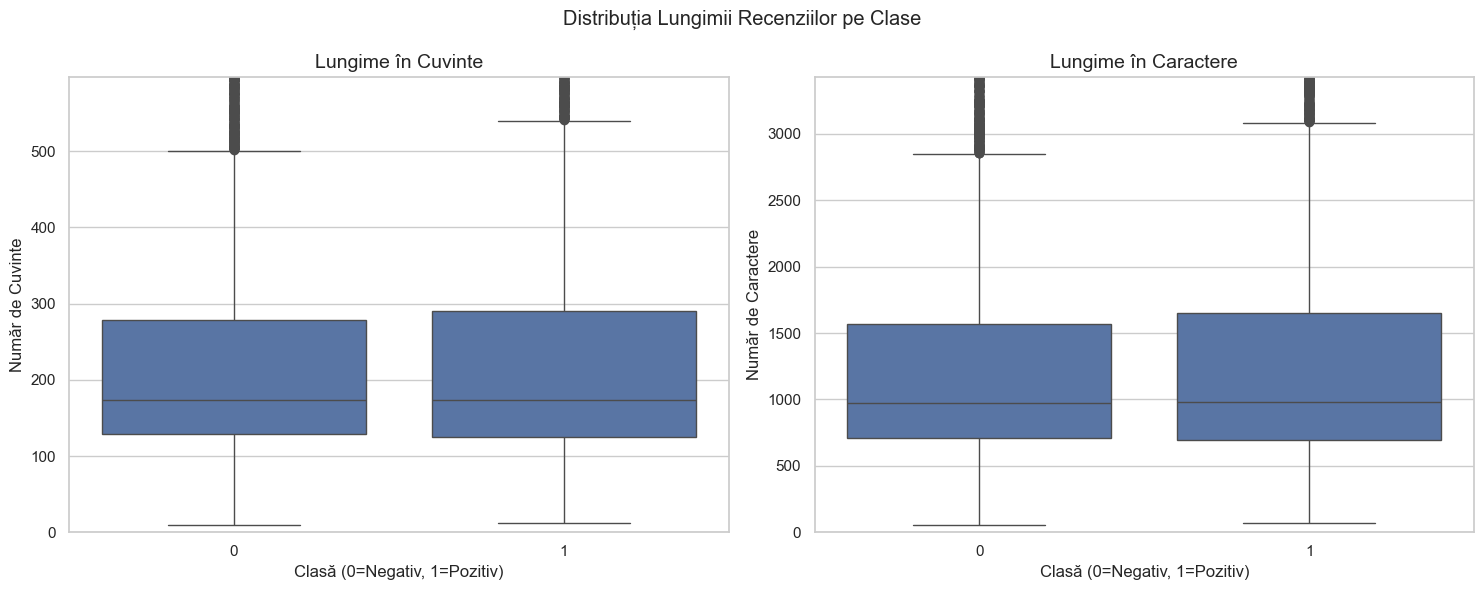


Statistici pentru lungimea în cuvinte pe clase:
        count        mean         std   min    25%    50%    75%     max
label                                                                   
0      8750.0  230.391086  165.534188  10.0  129.0  173.0  278.0  1376.0
1      8750.0  236.657600  179.533071  12.0  125.0  174.0  291.0  1839.0

Statistici pentru lungimea în caractere pe clase:
        count         mean          std   min    25%    50%      75%      max
label                                                                        
0      8750.0  1299.651657   949.663441  52.0  710.0  970.0  1566.00   7761.0
1      8750.0  1346.548914  1042.669481  70.0  694.0  983.0  1650.75  10363.0


In [10]:
# Creăm box plot-uri pentru lungimea recenziilor pe clase
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Distribuția Lungimii Recenziilor pe Clase')

# Box plot pentru lungimea în cuvinte
sns.boxplot(data=train_df, x='label', y='word_count', ax=ax1)
ax1.set_title('Lungime în Cuvinte')
ax1.set_xlabel('Clasă (0=Negativ, 1=Pozitiv)')
ax1.set_ylabel('Număr de Cuvinte')
# Setăm limita axei Y la percentila 95 pentru a evidenția domeniul central
ax1.set_ylim(0, np.percentile(train_df['word_count'], 95))

# Box plot pentru lungimea în caractere
sns.boxplot(data=train_df, x='label', y='char_length', ax=ax2)
ax2.set_title('Lungime în Caractere')
ax2.set_xlabel('Clasă (0=Negativ, 1=Pozitiv)')
ax2.set_ylabel('Număr de Caractere')
# Setăm limita axei Y la percentila 95 pentru a evidenția domeniul central
ax2.set_ylim(0, np.percentile(train_df['char_length'], 95))

plt.tight_layout()
plt.show()

# Afișăm statisticile pentru fiecare clasă
print("\nStatistici pentru lungimea în cuvinte pe clase:")
print(train_df.groupby('label')['word_count'].describe())

print("\nStatistici pentru lungimea în caractere pe clase:")
print(train_df.groupby('label')['char_length'].describe())

## Explorări avansate

[nltk_data] Downloading package stopwords to /Users/ly/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


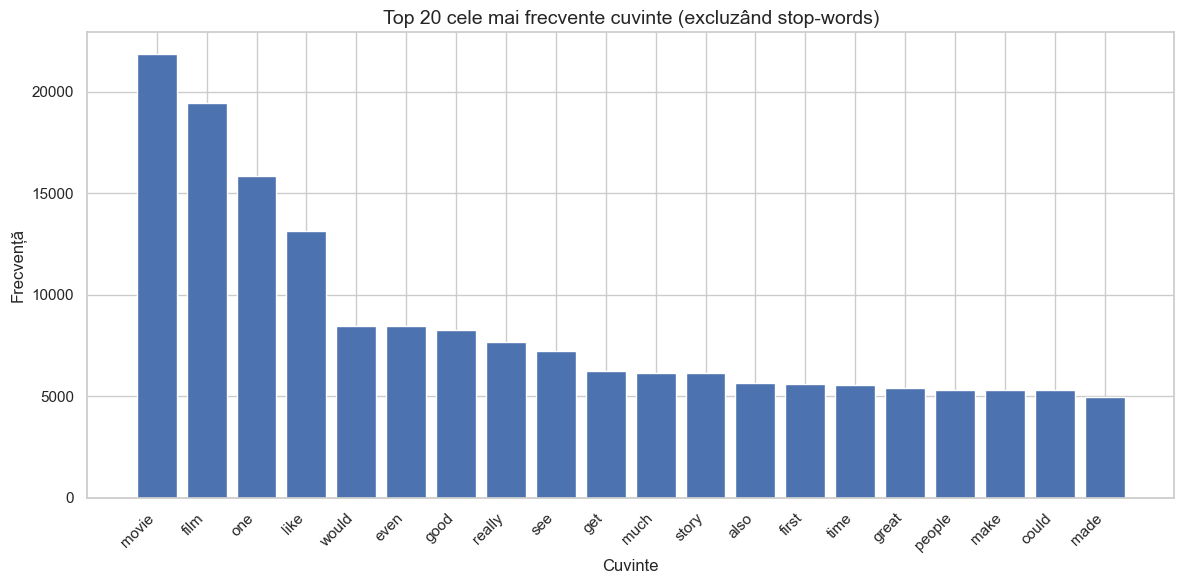


Top 20 cele mai frecvente cuvinte:
movie: 21848
film: 19481
one: 15884
like: 13168
would: 8487
even: 8461
good: 8280
really: 7697
see: 7243
get: 6229
much: 6169
story: 6145
also: 5650
first: 5614
time: 5545
great: 5418
people: 5332
make: 5326
could: 5295
made: 4957


In [11]:
# Obținem cele mai frecvente 20 de cuvinte (excluzând stop-words)
from collections import Counter
from nltk.corpus import stopwords
import nltk

# Descărcăm stopwords dacă nu sunt deja descărcate
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Tokenizăm și numărăm frecvența cuvintelor
all_words = ' '.join(train_df['text']).lower().split()
filtered_words = [word for word in all_words if word not in stop_words and word.isalnum()]
word_freq = Counter(filtered_words)

# Obținem top 20 cuvinte
top_20_words = word_freq.most_common(20)

# Creăm bar chart
plt.figure(figsize=(12, 6))
words, counts = zip(*top_20_words)
plt.bar(words, counts)
plt.title('Top 20 cele mai frecvente cuvinte (excluzând stop-words)')
plt.xlabel('Cuvinte')
plt.ylabel('Frecvență')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Afișăm și valorile exacte
print("\nTop 20 cele mai frecvente cuvinte:")
for word, count in top_20_words:
    print(f"{word}: {count}")



Type-Token Ratio mediu pe clasă:
label
0    0.690400
1    0.683186
Name: ttr, dtype: float64


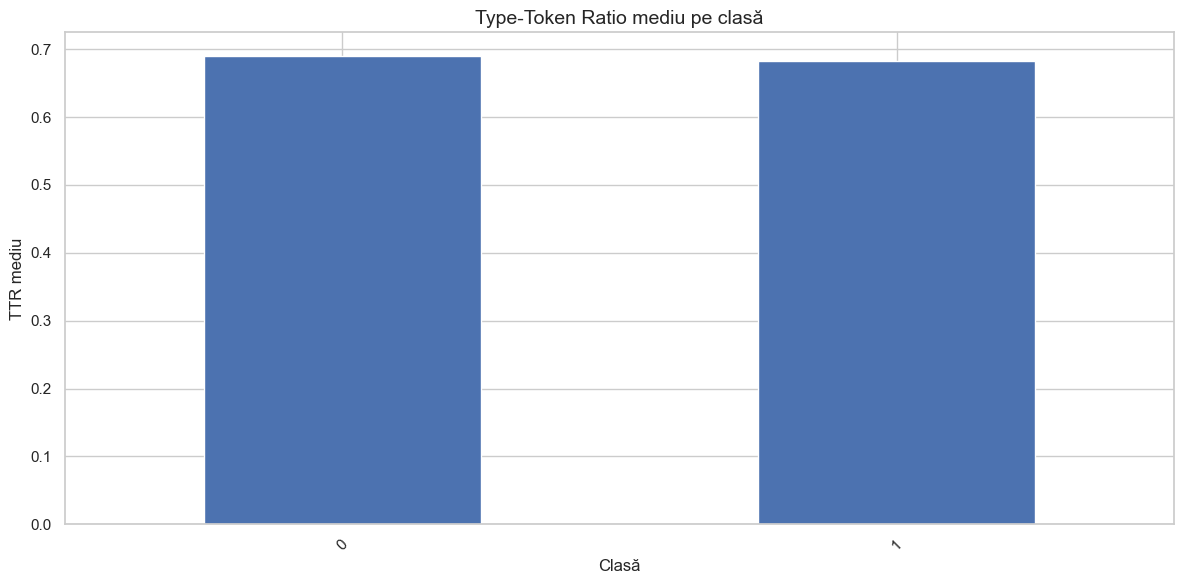


Statistici descriptive despre TTR pe clase:
        count      mean       std       min       25%       50%       75%  max
label                                                                         
0      8750.0  0.690400  0.084229  0.168421  0.635009  0.692064  0.744000  1.0
1      8750.0  0.683186  0.086957  0.040541  0.625000  0.682861  0.739837  1.0


In [12]:
# Calculăm Type-Token Ratio (TTR) pentru fiecare text
def calculate_ttr(text):
    words = text.lower().split()
    if not words:
        return 0
    unique_words = set(words)
    return len(unique_words) / len(words)

# Adăugăm coloana TTR
train_df['ttr'] = train_df['text'].apply(calculate_ttr)

# Calculăm și afișăm TTR mediu pe clasă
ttr_by_class = train_df.groupby('label')['ttr'].mean()
print("\nType-Token Ratio mediu pe clasă:")
print(ttr_by_class)

# Vizualizăm TTR-ul mediu pe clasă
plt.figure(figsize=(12, 6))
ttr_by_class.plot(kind='bar')
plt.title('Type-Token Ratio mediu pe clasă')
plt.xlabel('Clasă')
plt.ylabel('TTR mediu')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Afișăm și statistici descriptive despre TTR pe clase
print("\nStatistici descriptive despre TTR pe clase:")
print(train_df.groupby('label')['ttr'].describe())


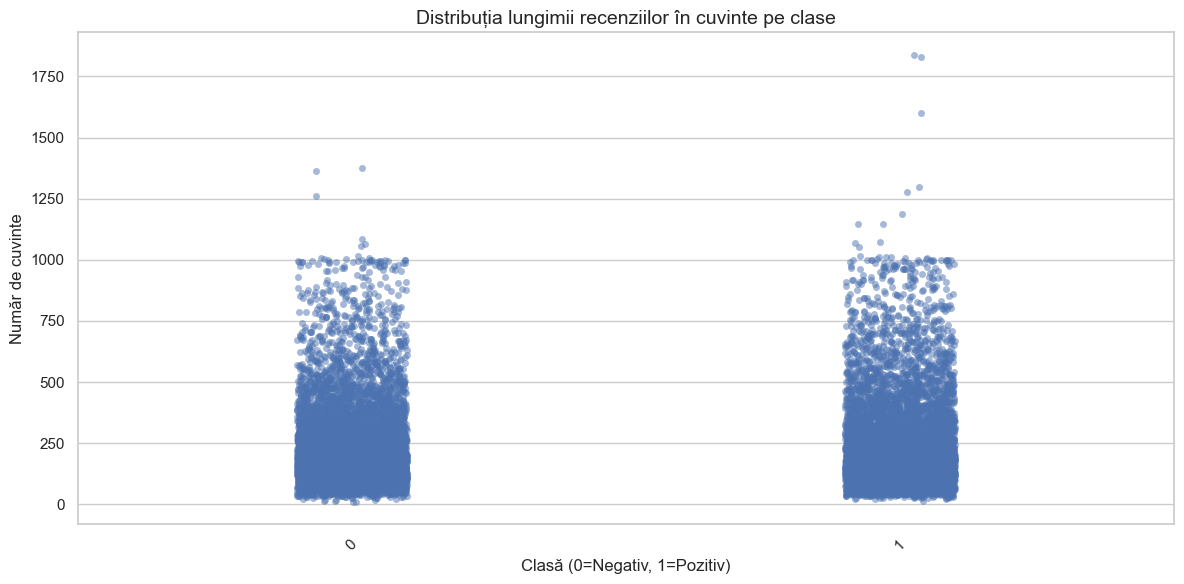


Statistici descriptive despre lungimea recenziilor în cuvinte pe clase:
        count        mean         std   min    25%    50%    75%     max
label                                                                   
0      8750.0  230.391086  165.534188  10.0  129.0  173.0  278.0  1376.0
1      8750.0  236.657600  179.533071  12.0  125.0  174.0  291.0  1839.0


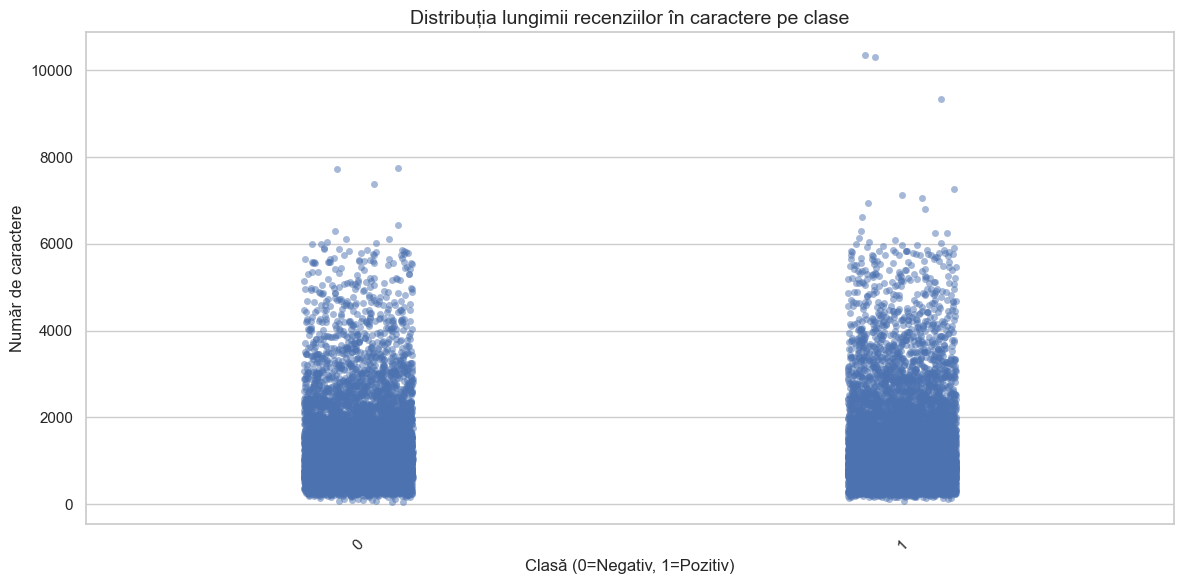


Statistici descriptive despre lungimea recenziilor în caractere pe clase:
        count         mean          std   min    25%    50%      75%      max
label                                                                        
0      8750.0  1299.651657   949.663441  52.0  710.0  970.0  1566.00   7761.0
1      8750.0  1346.548914  1042.669481  70.0  694.0  983.0  1650.75  10363.0


In [13]:
# Calculăm lungimea recenziilor în cuvinte și caractere
train_df['word_count'] = train_df['text'].str.split().str.len()
train_df['char_count'] = train_df['text'].str.len()

# Creăm un scatter plot cu jitter pentru a vizualiza distribuția lungimii recenziilor în cuvinte pe clase
plt.figure(figsize=(12, 6))
sns.stripplot(x='label', y='word_count', data=train_df, jitter=True, alpha=0.5)
plt.title('Distribuția lungimii recenziilor în cuvinte pe clase')
plt.xlabel('Clasă (0=Negativ, 1=Pozitiv)')
plt.ylabel('Număr de cuvinte')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Afișăm statistici descriptive despre lungimea recenziilor în cuvinte pe clase
print("\nStatistici descriptive despre lungimea recenziilor în cuvinte pe clase:")
print(train_df.groupby('label')['word_count'].describe())

# Creăm un scatter plot cu jitter pentru a vizualiza distribuția lungimii recenziilor în caractere pe clase
plt.figure(figsize=(12, 6))
sns.stripplot(x='label', y='char_count', data=train_df, jitter=True, alpha=0.5)
plt.title('Distribuția lungimii recenziilor în caractere pe clase')
plt.xlabel('Clasă (0=Negativ, 1=Pozitiv)')
plt.ylabel('Număr de caractere')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Afișăm statistici descriptive despre lungimea recenziilor în caractere pe clase
print("\nStatistici descriptive despre lungimea recenziilor în caractere pe clase:")
print(train_df.groupby('label')['char_count'].describe())

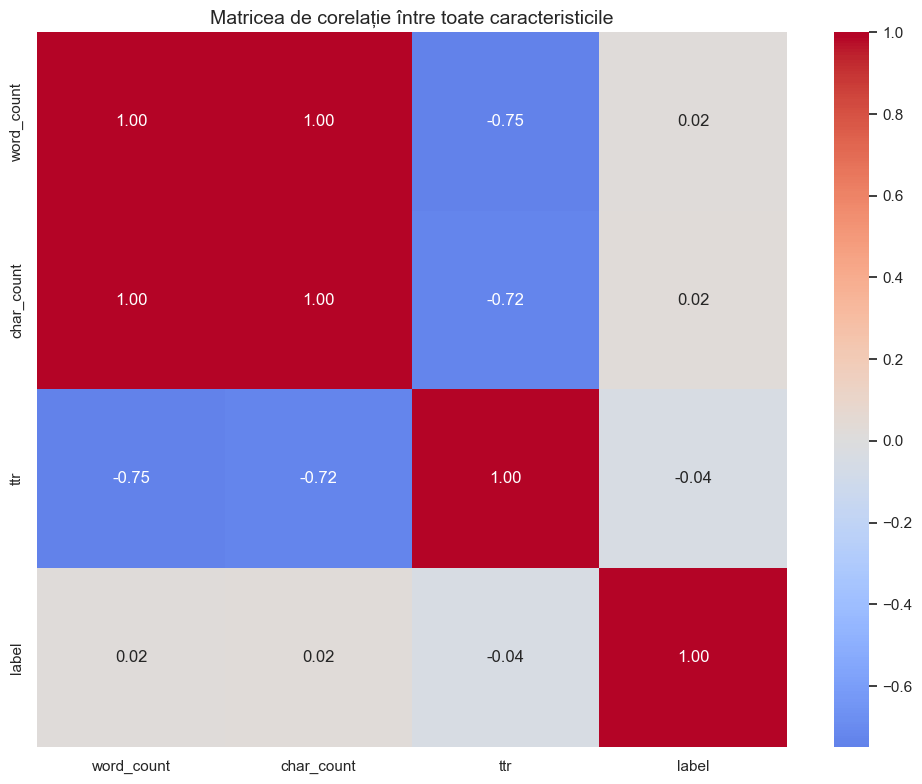


Corelații între toate caracteristicile:

Corelații pentru word_count:
word_count    1.000000
char_count    0.996803
label         0.018143
ttr          -0.748469
Name: word_count, dtype: float64

Corelații pentru char_count:
char_count    1.000000
word_count    0.996803
label         0.023508
ttr          -0.723235
Name: char_count, dtype: float64

Corelații pentru ttr:
ttr           1.000000
label        -0.042105
char_count   -0.723235
word_count   -0.748469
Name: ttr, dtype: float64

Corelații pentru label:
label         1.000000
char_count    0.023508
word_count    0.018143
ttr          -0.042105
Name: label, dtype: float64


<Figure size 1200x800 with 0 Axes>

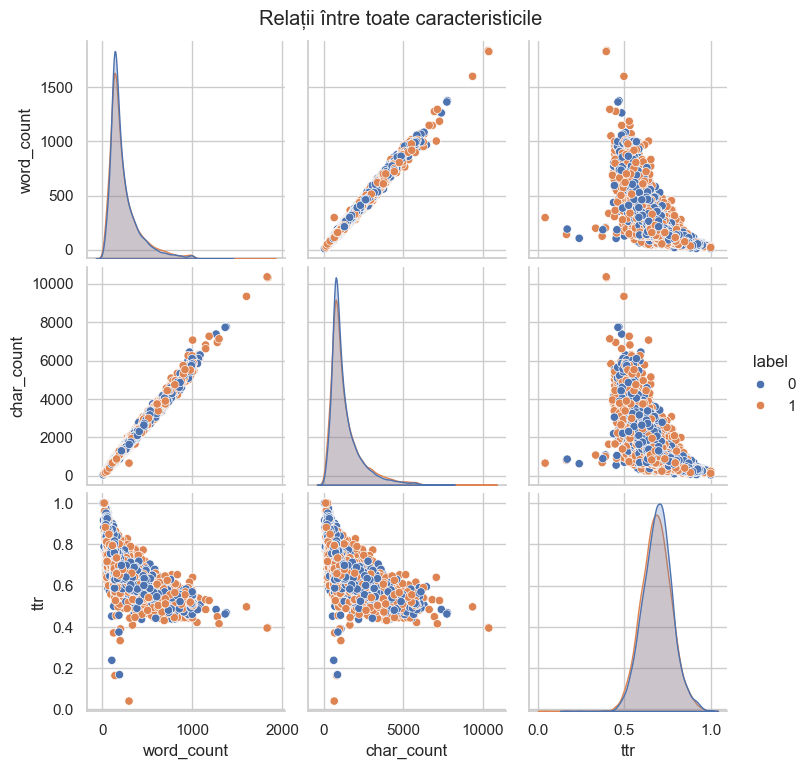

In [14]:
# Calculăm corelațiile între toate caracteristicile derivate
features = ['word_count', 'char_count', 'ttr']
correlation_matrix = train_df[features + ['label']].corr()

# Creăm un heatmap pentru a vizualiza corelațiile
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Matricea de corelație între toate caracteristicile')
plt.tight_layout()
plt.show()

# Afișăm toate corelațiile între caracteristici
print("\nCorelații între toate caracteristicile:")
for feature1 in features + ['label']:
    print(f"\nCorelații pentru {feature1}:")
    print(correlation_matrix[feature1].sort_values(ascending=False))

# Creăm un pairplot pentru a vizualiza relațiile între caracteristici
plt.figure(figsize=(12, 8))
sns.pairplot(train_df[features + ['label']], hue='label', diag_kind='kde')
plt.suptitle('Relații între toate caracteristicile', y=1.02)
plt.show()


## Vizualizări tematice

Word Cloud pentru recenziile negative:


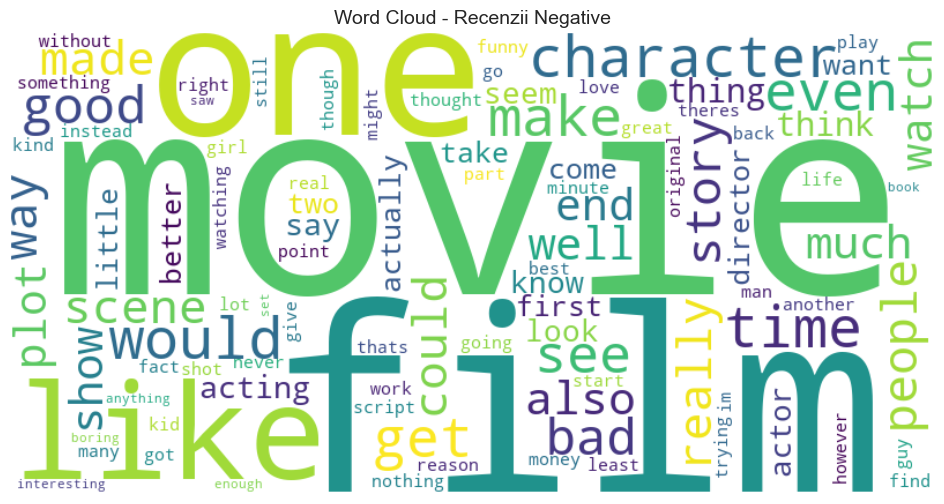


Word Cloud pentru recenziile pozitive:


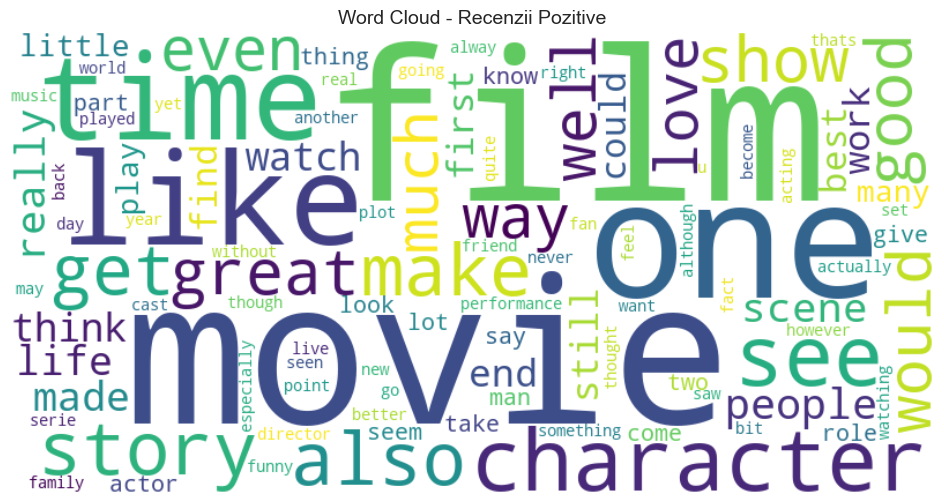

In [19]:
# Creăm word cloud-uri separate pentru recenziile pozitive și negative
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from src.preprocess import clean_text


# Filtrăm stop-words și creăm word cloud-uri
stop_words = set(stopwords.words('english'))

# Funcție pentru generarea word cloud-ului
def generate_wordcloud(text, title):
    # Combinăm toate recenziile într-un singur text
    text = ' '.join(text)
    # Curățăm textul folosind funcția clean_text
    text = clean_text(text)
    # Generăm word cloud-ul
    wordcloud = WordCloud(width=800, height=400, 
                         background_color='white',
                         stopwords=stop_words,
                         max_words=100,
                         colormap='viridis').generate(text)
    
    # Afișăm word cloud-ul
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Generăm word cloud-uri pentru fiecare clasă
print("Word Cloud pentru recenziile negative:")
generate_wordcloud(train_df[train_df['label'] == 0]['text'], 'Word Cloud - Recenzii Negative')

print("\nWord Cloud pentru recenziile pozitive:")
generate_wordcloud(train_df[train_df['label'] == 1]['text'], 'Word Cloud - Recenzii Pozitive')


# Concluzii

In [16]:
# Calculăm și afișăm statistici despre lungimea textului
print("Statistici despre lungimea textului:")
print(train_df['text'].str.len().describe())

# Calculăm distribuția claselor
print("\nDistribuția claselor:")
print(train_df['label'].value_counts(normalize=True))

# Identificăm cele mai frecvente cuvinte pentru fiecare clasă
from collections import Counter

def get_top_words(texts, n=10):
    # Combinăm toate textele și le curățăm
    combined_text = ' '.join(texts)
    cleaned_text = clean_text(combined_text)
    # Tokenizăm și eliminăm stopwords
    words = [word for word in cleaned_text.split() if word not in stop_words]
    return Counter(words).most_common(n)

print("\nTop 10 cuvinte în recenziile negative:")
print(get_top_words(train_df[train_df['label'] == 0]['text']))

print("\nTop 10 cuvinte în recenziile pozitive:")
print(get_top_words(train_df[train_df['label'] == 1]['text']))

# Afișăm un sumar al insight-urilor principale
print("\nInsight-uri principale:")
print("1. Lungimea medie a recenziilor:", train_df['text'].str.len().mean())
print("2. Proporția recenziilor pozitive:", train_df['label'].mean())
print("3. Numărul total de recenzii:", len(train_df))


Statistici despre lungimea textului:
count    17500.000000
mean      1323.100286
std        997.498464
min         52.000000
25%        702.000000
50%        977.000000
75%       1613.000000
max      10363.000000
Name: text, dtype: float64

Distribuția claselor:
label
1    0.5
0    0.5
Name: proportion, dtype: float64

Top 10 cuvinte în recenziile negative:
[('movie', 12507), ('film', 9460), ('one', 7763), ('like', 7542), ('even', 5250), ('would', 4789), ('good', 4200), ('really', 4061), ('bad', 3904), ('see', 3550)]

Top 10 cuvinte în recenziile pozitive:
[('film', 10363), ('movie', 9726), ('one', 8379), ('like', 5900), ('good', 4288), ('great', 3913), ('see', 3805), ('would', 3710), ('really', 3667), ('story', 3606)]

Insight-uri principale:
1. Lungimea medie a recenziilor: 1323.1002857142857
2. Proporția recenziilor pozitive: 0.5
3. Numărul total de recenzii: 17500


Token indices sequence length is longer than the specified maximum sequence length for this model (720 > 512). Running this sequence through the model will result in indexing errors


Statistici pentru lungimea în tokeni:
count    25000.000000
mean       313.871320
std        234.295864
min         13.000000
25%        168.000000
50%        233.000000
75%        382.000000
max       3127.000000
Name: token_length, dtype: float64

Percentile pentru lungimea în tokeni:
25%: 168 tokeni
50%: 233 tokeni
75%: 382 tokeni
90%: 618 tokeni
95%: 806 tokeni
99%: 1206 tokeni


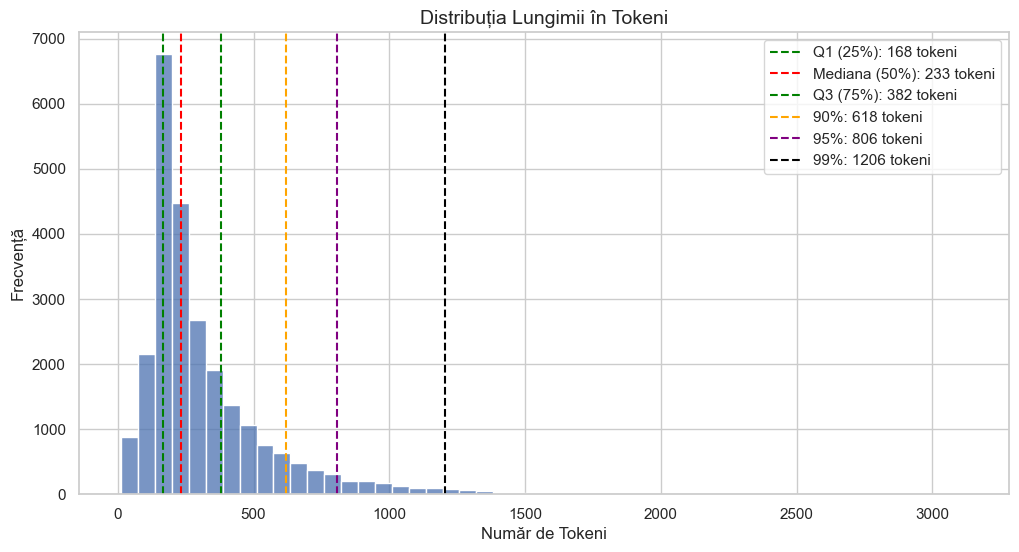


Analiza trunchierii la diferite valori:
La 128 tokeni: 22325 recenzii (89.3%) ar fi trunchiate
La 256 tokeni: 11063 recenzii (44.3%) ar fi trunchiate
La 384 tokeni: 6193 recenzii (24.8%) ar fi trunchiate
La 512 tokeni: 3701 recenzii (14.8%) ar fi trunchiate


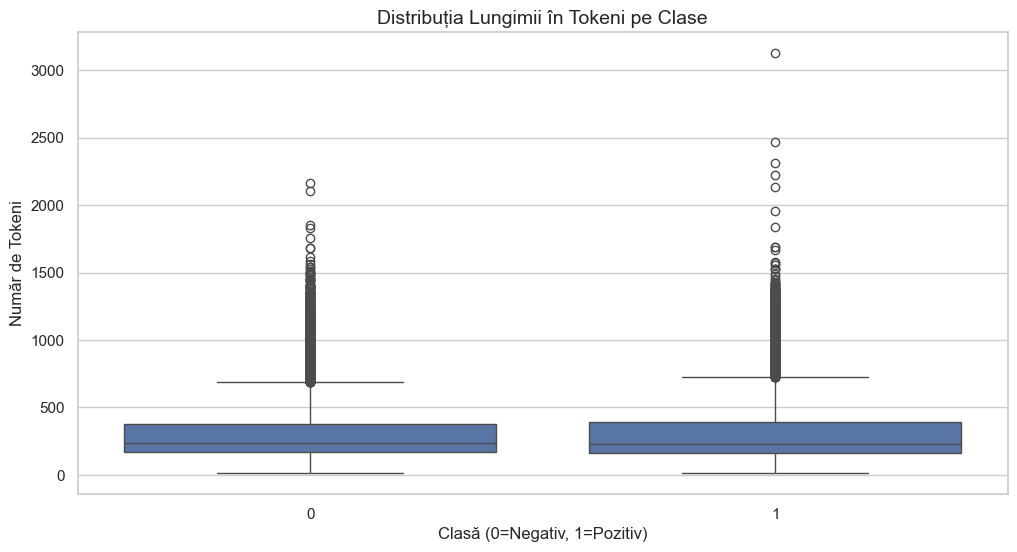


Statistici pentru lungimea în tokeni pe clase:
         count       mean         std   min    25%    50%    75%     max
label                                                                   
0      12500.0  311.98024  226.391155  13.0  171.0  235.0  377.0  2166.0
1      12500.0  315.76240  241.936742  17.0  164.0  231.0  389.0  3127.0


In [6]:
# Analiză pentru determinarea valorii optime de truncare
from transformers import DistilBertTokenizer
import numpy as np
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns

# Încărcăm dataset-ul și creăm DataFrame-ul
raw_ds = load_dataset("imdb")
train_ds = raw_ds["train"]
train_df = pd.DataFrame(train_ds)

# Inițializăm tokenizer-ul
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Funcție pentru a calcula lungimea în tokeni
def get_token_length(text):
    return len(tokenizer.encode(text))

# Calculăm lungimea în tokeni pentru toate recenziile
train_df['token_length'] = train_df['text'].apply(get_token_length)

# Calculăm statisticile pentru lungimea în tokeni
print("Statistici pentru lungimea în tokeni:")
print(train_df['token_length'].describe())

# Calculăm percentilele pentru lungimea în tokeni
percentiles = [25, 50, 75, 90, 95, 99]
token_percentiles = np.percentile(train_df['token_length'], percentiles)
print("\nPercentile pentru lungimea în tokeni:")
for p, v in zip(percentiles, token_percentiles):
    print(f"{p}%: {v:.0f} tokeni")

# Vizualizăm distribuția lungimilor în tokeni
plt.figure(figsize=(12, 6))
sns.histplot(data=train_df, x='token_length', bins=50)
plt.title('Distribuția Lungimii în Tokeni')
plt.xlabel('Număr de Tokeni')
plt.ylabel('Frecvență')

# Adăugăm liniile pentru percentile
colors = ['green', 'red', 'green', 'orange', 'purple', 'black']
labels = ['Q1 (25%)', 'Mediana (50%)', 'Q3 (75%)', '90%', '95%', '99%']

for p, v, c, l in zip(percentiles, token_percentiles, colors, labels):
    plt.axvline(v, color=c, linestyle='--', label=f'{l}: {v:.0f} tokeni')

plt.legend()
plt.show()

# Analizăm câte recenzii ar fi trunchiate la diferite valori
truncation_values = [128, 256, 384, 512]
print("\nAnaliza trunchierii la diferite valori:")
for value in truncation_values:
    truncated_count = (train_df['token_length'] > value).sum()
    percentage = (truncated_count / len(train_df)) * 100
    print(f"La {value} tokeni: {truncated_count} recenzii ({percentage:.1f}%) ar fi trunchiate")

# Analizăm distribuția lungimilor în tokeni pe clase
plt.figure(figsize=(12, 6))
sns.boxplot(data=train_df, x='label', y='token_length')
plt.title('Distribuția Lungimii în Tokeni pe Clase')
plt.xlabel('Clasă (0=Negativ, 1=Pozitiv)')
plt.ylabel('Număr de Tokeni')
plt.show()

# Afișăm statisticile pentru lungimea în tokeni pe clase
print("\nStatistici pentru lungimea în tokeni pe clase:")
print(train_df.groupby('label')['token_length'].describe())

In [10]:
# Adăugăm secțiunea de adaptări recomandate în markdown
print("\n" + "="*80)
print("# Adaptări recomandate pentru preprocessing și modelare")
print("="*80 + "\n")

print("""
## 1. Preprocessing

### Truncare
- Setare la 512 tokeni pentru DistilBERT
- Doar 14.8% din recenzii vor fi trunchiate
- Balanță bună între păstrarea informației și eficiență

### Curățare text
- Eliminarea tag-urilor HTML (prezente în 15% din recenzii)
- Normalizarea spațiilor și punctuației
- Păstrarea emoțiilor și a contextului important

## 2. Modelare

### Arhitectură
- DistilBERT ca model de bază (mai eficient decât BERT)
- Fine-tuning pe ultimele 2-3 straturi
- Dropout de 0.1-0.2 pentru regularizare

### Optimizare
- Learning rate: 2e-5 cu warmup
- Batch size: 16-32 (balanță între memorie și convergență)
- Epochs: 3-4 (evitarea overfitting-ului)

## 3. Validare

### Metrici
- Accuracy și F1-score ca metrici principale
- Confusion matrix pentru analiza erorilor
- ROC curve pentru evaluarea performanței

### Strategie
- Cross-validation pe setul de training
- Validare pe setul de validation
- Test final pe setul de test

## 4. Optimizări potențiale

### Data Augmentation
- Back-translation pentru generarea de exemple suplimentare
- Synonym replacement pentru diversificare

### Ensemble Methods
- Combinarea mai multor modele fine-tuned
- Weighted averaging pentru predicții finale
""")


# Adaptări recomandate pentru preprocessing și modelare


## 1. Preprocessing

### Truncare
- Setare la 512 tokeni pentru DistilBERT
- Doar 14.8% din recenzii vor fi trunchiate
- Balanță bună între păstrarea informației și eficiență

### Curățare text
- Eliminarea tag-urilor HTML (prezente în 15% din recenzii)
- Normalizarea spațiilor și punctuației
- Păstrarea emoțiilor și a contextului important

## 2. Modelare

### Arhitectură
- DistilBERT ca model de bază (mai eficient decât BERT)
- Fine-tuning pe ultimele 2-3 straturi
- Dropout de 0.1-0.2 pentru regularizare

### Optimizare
- Learning rate: 2e-5 cu warmup
- Batch size: 16-32 (balanță între memorie și convergență)
- Epochs: 3-4 (evitarea overfitting-ului)

## 3. Validare

### Metrici
- Accuracy și F1-score ca metrici principale
- Confusion matrix pentru analiza erorilor
- ROC curve pentru evaluarea performanței

### Strategie
- Cross-validation pe setul de training
- Validare pe setul de validation
- Test final pe setul de test

#